<a href="https://colab.research.google.com/github/w1t1ta/pre_project/blob/main/Preproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ติดตั้ง Kaggle API
!pip install kaggle

# สร้างโฟลเดอร์ .kaggle และอัปโหลดไฟล์ kaggle.json
import os
from google.colab import files


In [ ]:
os.makedirs("/root/.kaggle", exist_ok=True)
uploaded = files.upload()  # เลือกอัปโหลดไฟล์ kaggle.json

# ย้ายไฟล์ไปที่โฟลเดอร์ .kaggle
!mv kaggle.json /root/.kaggle/

# ตั้งค่าสิทธิ์ให้ไฟล์ใช้งานได้
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

!kaggle datasets download -d mostafaabla/garbage-classification
!unzip garbage-classification.zip -d /content/garbage_classification

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: /content/garbage_classification/garbage_classification/paper/paper381.jpg  
  inflating: /content/garbage_classification/garbage_classification/paper/paper382.jpg  
  inflating: /content/garbage_classification/garbage_classification/paper/paper383.jpg  
  inflating: /content/garbage_classification/garbage_classification/paper/paper384.jpg  
  inflating: /content/garbage_classification/garbage_classification/paper/paper385.jpg  
  inflating: /content/garbage_classification/garbage_classification/paper/paper386.jpg  
  inflating: /content/garbage_classification/garbage_classification/paper/paper387.jpg  
  inflating: /content/garbage_classification/garbage_classification/paper/paper388.jpg  
  inflating: /content/garbage_classification/garbage_classification/paper/paper389.jpg  
  inflating: /content/garbage_classification/garbage_classification/paper/paper39.jpg  
  inflating: /content/garbage_classification/garbage_c

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random
import shutil             # to copy images to another directory
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix

from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D , BatchNormalization ,Dropout ,Flatten , Dense , Input , Rescaling , Resizing
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

plt.style.use('ggplot')

In [ ]:
import os
import pandas as pd

dataDirList = ['/content/garbage_classification/garbage_classification']

selectedClasses = ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic', 'white-glass']
imgPaths = []
labels = []

for dataDir in dataDirList:
    for className in os.listdir(dataDir):
        if className in selectedClasses:
            classPath = os.path.join(dataDir, className)
            for img in os.listdir(classPath):
                imgPath = os.path.join(classPath, img)
                imgPaths.append(imgPath)
                if className == 'white-glass':
                    className = 'glass'
                labels.append(className)

# Convert the 2 lists to dataframe to make it easier to use
df = pd.DataFrame({
    'imgPath': imgPaths,
    'label': labels
})

df = df.sample(frac=1).reset_index(drop=True)  # Shuffle the dataframe
df

,imgPath,label
0,/content/garbage_classification/garbage_classi...,plastic
1,/content/garbage_classification/garbage_classi...,plastic
2,/content/garbage_classification/garbage_classi...,metal
3,/content/garbage_classification/garbage_classi...,cardboard
4,/content/garbage_classification/garbage_classi...,plastic
...,...,...
5042,/content/garbage_classification/garbage_classi...,metal
5043,/content/garbage_classification/garbage_classi...,paper
5044,/content/garbage_classification/garbage_classi...,glass
5045,/content/garbage_classification/garbage_classi...,cardboard


In [ ]:
# get the ratio such as 15% of each class for testing
def DataFrameSpliting(df , ratio , classesList):

    trainDf = pd.DataFrame(columns = ['imgPath','label'])
    testDf = pd.DataFrame(columns = ['imgPath','label'])
    for clas in classesList :
        tempDf = df[df['label'] == clas]
        lastIndex = int(len(tempDf) * ratio)
        trainClassDf = tempDf[:lastIndex]
        testClassDf = tempDf[lastIndex:]
        trainDf = pd.concat([trainDf , trainClassDf] , axis=0)
        testDf = pd.concat([testDf , testClassDf] , axis=0)

    return trainDf.sample(frac=1).reset_index(drop=True) , testDf.sample(frac=1).reset_index(drop=True)  # shuffling , reset index

In [ ]:
classList = list(df['label'].unique())
trainDf , testDf = DataFrameSpliting(df , 0.85 , classList)

trainDf

,imgPath,label
0,/content/garbage_classification/garbage_classi...,paper
1,/content/garbage_classification/garbage_classi...,plastic
2,/content/garbage_classification/garbage_classi...,trash
3,/content/garbage_classification/garbage_classi...,trash
4,/content/garbage_classification/garbage_classi...,glass
...,...,...
4282,/content/garbage_classification/garbage_classi...,glass
4283,/content/garbage_classification/garbage_classi...,metal
4284,/content/garbage_classification/garbage_classi...,metal
4285,/content/garbage_classification/garbage_classi...,glass


In [ ]:
trainDf['label'].value_counts()

,count
label,
paper,892
cardboard,757
plastic,735
glass,658
metal,653
trash,592


In [ ]:
testDf

,imgPath,label
0,/content/garbage_classification/garbage_classi...,cardboard
1,/content/garbage_classification/garbage_classi...,cardboard
2,/content/garbage_classification/garbage_classi...,metal
3,/content/garbage_classification/garbage_classi...,glass
4,/content/garbage_classification/garbage_classi...,metal
...,...,...
755,/content/garbage_classification/garbage_classi...,glass
756,/content/garbage_classification/garbage_classi...,metal
757,/content/garbage_classification/garbage_classi...,cardboard
758,/content/garbage_classification/garbage_classi...,paper


In [ ]:
testDf['label'].value_counts()

,count
label,
paper,158
cardboard,134
plastic,130
glass,117
metal,116
trash,105


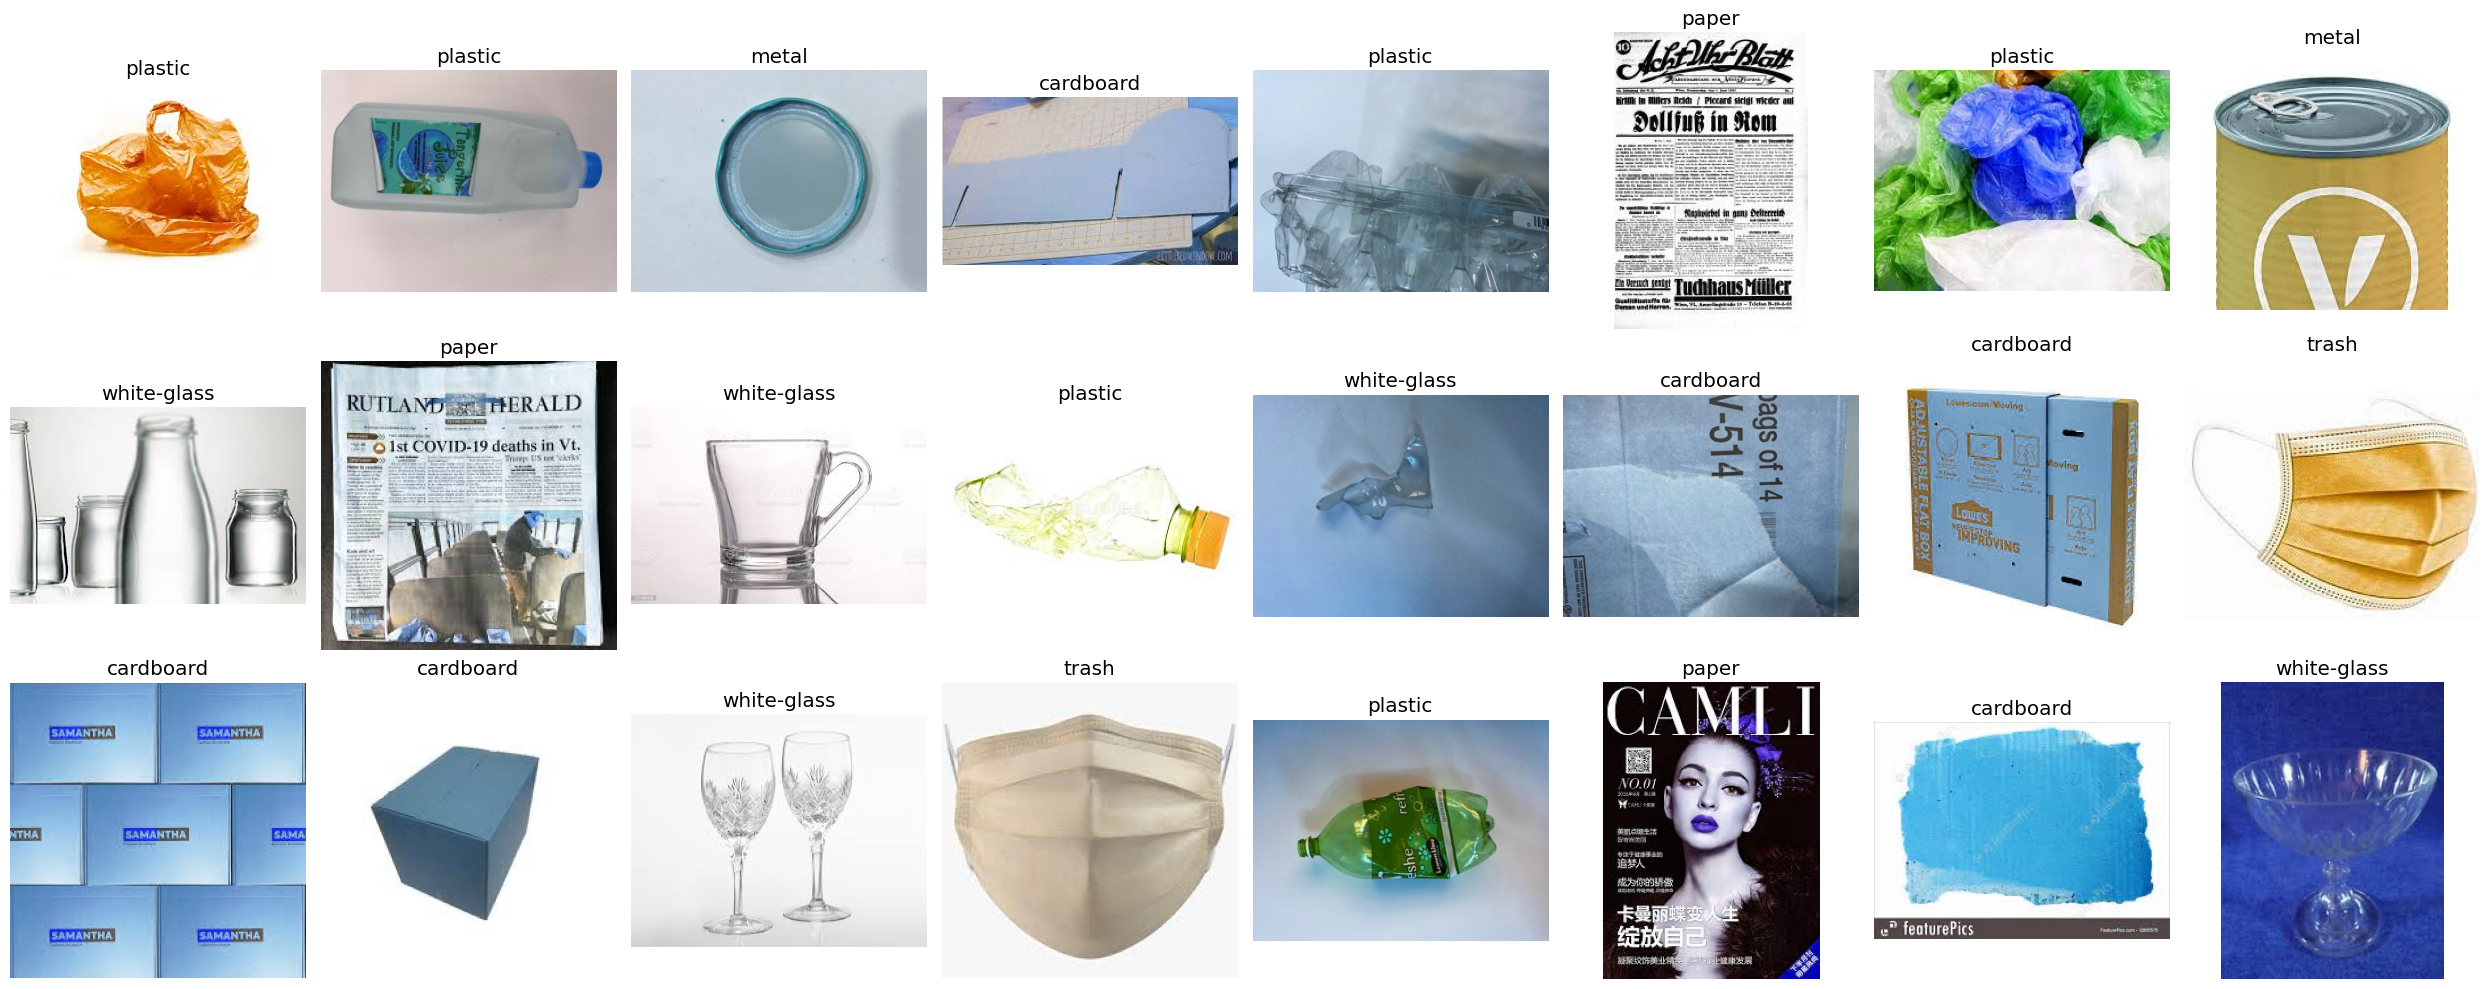

In [ ]:
imgPaths = df['imgPath']
fig, axs = plt.subplots(3, 8, figsize=(25, 10))

axs = axs.flatten()

for ax,imgPath in zip(axs , imgPaths):
    label = str(imgPath).split('/')[-2]    # extract label of an imgae from a path
    img = cv2.imread(imgPath)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
datagenTrain = ImageDataGenerator(
            rescale=1./255,
            zoom_range=(1.0, 1.2),   # zoom in
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=11.25,
            brightness_range=(1,1.5),
)

In [ ]:
IMG_SIZE = (224,224)

trainGenerator = datagenTrain.flow_from_dataframe(
    trainDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=64 ,                    # Generate 64 image from the datagenTrain (flipped , rotated , zoomed , ....)  at once
    class_mode='categorical'
)


datagenTest = ImageDataGenerator( rescale=1./255 )

testGenerator = datagenTest.flow_from_dataframe(
    testDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=8 ,
    class_mode='categorical',
    shuffle=False
)


print(f"Training set size: {trainGenerator.samples}")
print(f"Testing set size: {testGenerator.samples}")

Found 4287 validated image filenames belonging to 6 classes.
Found 760 validated image filenames belonging to 6 classes.
Training set size: 4287
Testing set size: 760


In [ ]:
with tf.device('/GPU:0'):          # to use GPU
    Model = Sequential([

#         Resizing(IMG_SIZE),

#         Rescaling(1./255),     These two steps ,we did perform them above with test and image generator

        MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)),

        Flatten(),                                     # because we ignore the flatten and dense layers when include_top = False

        Dense(64,activation='relu'),

        BatchNormalization(),

        Dropout(0.08),

        Dense(6 ,activation='softmax')
    ])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
preTrainedModel = Model.layers[0]
for layer in preTrainedModel.layers[:-4]:           # freez all layers except the first and last 3 layers, we will make them trainable (weghts changes with training)
    layer.trainable = False

In [ ]:
Model.compile(optimizer='adam',loss='categorical_crossentropy' ,metrics=['accuracy'])


In [ ]:
history = Model.fit(trainGenerator,
                    validation_data = testGenerator,
                    epochs=50,
#                     batch_size=64,   # we define it above inside trainGenerator
                    verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                                       patience=10,
                                       monitor='val_accuracy',
                                       restore_best_weights=True)])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 273s 4s/step - accuracy: 0.6841 - loss: 0.9239 - val_accuracy: 0.8382 - val_loss: 0.4913
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - accuracy: 0.8791 - loss: 0.3730 - val_accuracy: 0.8618 - val_loss: 0.3780
Epoch 3/50
49/67 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/step - accuracy: 0.9040 - loss: 0.2876

In [ ]:
Model.summary()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = Model.predict(testGenerator)

In [ ]:
trainGenerator.class_indices


In [ ]:
trueClasses = testGenerator.classes
trueClasses[:10]

In [ ]:
predictedClasses = predictions.argmax(axis=-1)
predictedClasses[:10]

In [ ]:
test_loss, test_accuracy = Model.evaluate(testGenerator)
test_accuracy

In [ ]:
CM = confusion_matrix(trueClasses, predictedClasses)
sns.heatmap(CM, center = True,cmap='terrain',annot=True ,fmt='.5g')
plt.show()

In [ ]:
ClassificationReport = classification_report(trueClasses, predictedClasses)
print('Classification Report is : \n', ClassificationReport )

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, f1_score

datagenTrainEval = ImageDataGenerator(rescale=1./255)
trainGeneratorEval = datagenTrainEval.flow_from_dataframe(
    trainDf,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

trainPredictions = Model.predict(trainGeneratorEval, verbose=1)

trueClasses_train = trainGeneratorEval.classes
predictedClasses_train = trainPredictions.argmax(axis=-1)

ClassificationReport_train = classification_report(trueClasses_train, predictedClasses_train)
print('Classification Report for Training Data:\n', ClassificationReport_train)

macroF1_train = f1_score(trueClasses_train, predictedClasses_train, average='macro')
print('Macro Average F1 Score for Training Data:', macroF1_train)

In [ ]:
images = []
predictedClasses = []
trueClasses = []


class_labels = list(testGenerator.class_indices.keys())

for i in range(len(testGenerator)):
    img_batch, true_labels_batch = next(testGenerator)  # Get next batch
    true_class_idx = np.argmax(true_labels_batch[0])  # Get the true class index

    # Predict the class for the image
    prediction = Model.predict(img_batch)
    predicted_class_idx = np.argmax(prediction[0])  # Get the predicted class index

    # Convert the class indices to class labels
    predicted_class = class_labels[predicted_class_idx]
    true_class = class_labels[true_class_idx]

    images.append(np.squeeze(img_batch[0]))
    predictedClasses.append(predicted_class)
    trueClasses.append(true_class)

    if i >= 24:  # For example, only plot 24 images
        break

In [ ]:
fig, axs = plt.subplots(3, 8, figsize=(25, 10))


axs = axs.flatten()

for ax,img , pred , true in zip(axs , images , predictedClasses , trueClasses):
    ax.imshow(img)
    ax.set_title(f"Pred: {pred}, True: {true}" ,fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Save model
Model.save('garbage_classifier_model.h5')

# Load model
from tensorflow.keras.models import load_model
model = load_model('garbage_classifier_model.h5')

In [ ]:
import requests
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from PIL import Image

# ลิสต์ของ URL รูปภาพ
urls = [
    "https://static.thairath.co.th/media/4DQpjUtzLUwmJZZSE5QYIsx4YaDi2gpjSgvAnIpr8NZX.jpg",
    "https://as1.ftcdn.net/v2/jpg/09/23/42/84/1000_F_923428491_cbrW888OUwHbKnSbPPNLFVxVnI4HUHTM.jpg",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ05L1JnqgIiPqKeNrYyBpJ5DMz4tNDoUb4xw&s",
    "https://t3.ftcdn.net/jpg/01/15/72/68/360_F_115726887_NVwvYTJylRHGHFWsd8d6g5vr4Zgn8iVL.jpg",
    "https://markhammetals.com/wp-content/uploads/2014/12/metal-photo.jpg"
]

# กำหนดขนาดที่โมเดลคาดหวัง
IMG_SIZE = (224, 224)  # หรือขนาดที่โมเดลของคุณคาดหวัง

images = []

# ดาวน์โหลดและแปลงรูปภาพเป็น array
for url in urls:
    img_data = requests.get(url).content
    img_arr = np.asarray(bytearray(img_data), dtype=np.uint8)
    img = cv2.imdecode(img_arr, -1)  # Decode image
    img_resized = cv2.resize(img, IMG_SIZE)  # ปรับขนาดให้ตรงกับขนาดที่โมเดลคาดหวัง
    img_array = img_to_array(img_resized)  # แปลงเป็น array
    images.append(img_array)

# เปลี่ยนลิสต์ของรูปภาพเป็น array
images_array = np.array(images)

# ปรับสเกลภาพให้เหมาะสม
images_array /= 255.0  # นำค่ารูปภาพให้มีช่วงค่า [0, 1]

In [ ]:
predictions = model.predict(images_array)

# แสดงผลทำนาย
for i, prediction in enumerate(predictions):
    predicted_class = prediction.argmax()  # หาคลาสที่มีคะแนนสูงสุด
    predicted_label = class_labels[predicted_class]  # นำค่า index ไปใช้หาชื่อคลาส
    print(f"Image {i+1}: Predicted class is {predicted_label}")

    # แสดงรูปภาพและผลทำนาย
    response = requests.get(urls[i], stream=True).raw
    image = np.asarray(bytearray(response.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    if image is not None:
        img = Image.fromarray(image)  # เปิดรูปภาพด้วย PIL

        # แสดงรูปและข้อความทำนาย
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"Prediction: {predicted_label}")  # แสดงข้อความทำนาย
        plt.axis('off')  # ซ่อนแกน
        plt.show()